# Import design libraries

In [1]:
import sys
sys.path.append('..')

In [2]:
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [3]:
watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer

# Specify constants, everything in microns

In [4]:
tl_core = 20
tl_gap = 12
tl_ground = 100

# Sample generation

## borders with pads

In [5]:
reload(gdspy)
reload(creator)
#reload(elements)
layers_configuration={
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

#specify pads for the sample

p1 = elements.Pad('p1', (1000,   2350), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (8700,  2350), 0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
#sample.add_pad('p1', tl_core, tl_gap, tl_ground, (810,  2350), 50, np.pi, sample.layer_configuration, sample.chip_geometry)
#sample.add_pad('p2', tl_core, tl_gap, tl_ground, (8890, 2350), 50, np.pi, sample.layer_configuration, sample.chip_geometry)
#generate borders with pads
#sample.generate_sample_edges_and_pads()
sample.add(p1)
sample.add(p2)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)
#chip_edge_ground.render()
dist = 1000
end_element = p1
end_port = 'port'

n1 = elements.Narrowing(name = 'adapter', 
                        position = (p1.position[0]+dist, p1.position[1]), 
                        orientation = 0,
                        w1 = tl_core,
                        s1 = tl_gap,
                        g1 = tl_ground,
                        w2 = tl_core*5,
                        s2 = tl_gap,
                        g2 = tl_ground*2,
                        layer_configuration = sample.layer_configuration,
                        length = 200)
n2 = elements.Narrowing(name = 'adapter', 
                        position = (p1.position[0]+7*dist, p1.position[1]), 
                        orientation = 0,
                        w2 = tl_core,
                        s2 = tl_gap,
                        g2 = tl_ground,
                        w1 = tl_core*5,
                        s1 = tl_gap,
                        g1 = tl_ground*2,
                        layer_configuration = sample.layer_configuration,
                        length = 200)


ab1  =elements.CPWGroundAirBridge(name='ab1', 
                                  position=(p1.position[0]+(5)*dist, p1.position[1]), 
                                  orientation=0, 
                                  geometry=ChichkovAB,
                                  w = tl_core,
                                  s = tl_gap,
                                  g = tl_ground,
                                  layer_configuration=sample.layer_configuration,
                                  l=0,
                                  c=0)
sample.add(n1)
sample.add(n2)
#sample.add(ab1)
sample.connect_cpw(p1, n1, 'port', 'port1', 
                   'feedline-narrow-el', [])
sample.connect_cpw(n1, n2, 'port2', 'port1', 
                   'feedline-thick-el', [(5000, 1000), (6000, 1000)])
#sample.connect_cpw(n2, ab1, 'port2', 'port1', 
#                   'feedline-thick-el2', [n2.get_terminals()['port2'].position, (5000, 1000), (6000, 1000), 
#                                          ab1.get_terminals()['port1'].position])

#sample.connect_cpw(ab1, p2, 'port2', 'port', 'feedline', 
#                   [ab1.get_terminals()['port2'].position, p2.get_terminals()['port'].position])

#sample.connect_cpw(p1, p2, 'port', 'port', 'feedline', 
#                   [p1.get_terminals()['port'].position, p2.get_terminals()['port'].position])

sample.connect_cpw(n2, p2, 'port2', 'port', 
                   'feedline-thick-el2', [])


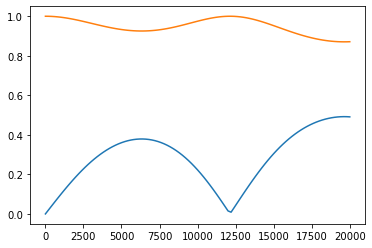

In [6]:
f = np.linspace(1, 20e3, 101)
s11 = sample.get_s21('p1', 'p1', f)
s21 = sample.get_s21('p1', 'p2', f)
from matplotlib import pyplot as plt
plt.plot(f, np.abs(s11))
plt.plot(f, np.abs(s21))

In [7]:
sys, connections, elements_ = sample.get_tls()

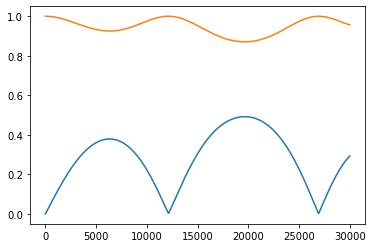

In [27]:
frequencies = np.linspace(1, 30e3, 1001)
fields = []
for f_id, f in enumerate(frequencies):
    eq_vi, eq_dof = sys.get_element_dynamic_equations(elements_['p1'][0])
    v1, i1, a1 = sys.get_element_dofs(elements_['p1'][0])
    v2, i2, a2 = sys.get_element_dofs(elements_['p2'][0])
    m = sys.create_boundary_problem_matrix(f*np.pi*2)
    boundary = np.zeros(len(sys.dof_mapping))
    boundary[eq_vi] = 1
    fields.append(np.linalg.solve(m, boundary))
#plt.plot(frequencies, np.abs(np.asarray(fields)[:, v1[0]]))
plt.plot(frequencies, np.abs(np.asarray(fields)[:, a1[0]]))
plt.plot(frequencies, np.abs(np.asarray(fields)[:, a2[0]]))

In [28]:
design = sample.draw_design()
watch()

<ipython-input-3-1fe8b7b94d80>:1: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [29]:
design.write_gds('results/test_ilya1.gds')

In [39]:
v2

[1]

In [36]:
np.round(np.real((sys.create_boundary_problem_matrix(0))),4)

array([[  1.,  50.,   0.],
       [  1., -50.,   1.],
       [  0.,   1.,   0.]])

In [33]:
np.sqrt(elements_['feedline'][0].Ll/elements_['feedline'][0].Cl)

array([[50.90224235]])

In [20]:
elements_, np.round(m, 2)

({'p1': [<QCreator.transmission_line_simulator.Port at 0x2537f1735b0>],
  'p2': [<QCreator.transmission_line_simulator.Port at 0x2537f173370>],
  'chip_edge_ground': [],
  'feedline': [<QCreator.transmission_line_simulator.TLCoupler at 0x2537f173640>]},
 array([[ 1.0e+00+0.j  ,  0.0e+00+0.j  ,  0.0e+00+0.j  ,  0.0e+00+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.j  ,  5.0e+01+0.j  ,  0.0e+00+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.j  ],
        [ 0.0e+00+0.j  ,  0.0e+00+0.j  , -1.0e+00+0.j  ,  0.0e+00+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.j  ,  1.0e+00+0.j  ,  0.0e+00+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.j  ],
        [ 0.0e+00+0.j  ,  1.0e+00+0.j  ,  0.0e+00+0.j  ,  0.0e+00+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.j  ,  0.0e+00+0.j  ,  5.0e+01+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.j  ],
        [ 0.0e+00+0.j  ,  0.0e+00+0.j  ,  0.0e+00+0.j  , -1.0e+00+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.j  ,  0.0e+00+0.j  ,  1.0e+00+0.j  ,
          0.0e+00+0.j  ,  0.0e+00+0.

In [24]:
elements_['feedline'][0].l

7699.837999945999

In [6]:
watch()

<ipython-input-3-1fe8b7b94d80>:1: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [9]:
sample.objects[-1].segments

[{'type': 'endpoint', 'endpoint': array([6015., 2350.])},
 {'type': 'segment', 'endpoint': array([6015.16200005, 2350.        ])},
 {'type': 'turn', 'turn': 0.0},
 {'type': 'segment', 'endpoint': array([8699.83799995, 2350.        ])},
 {'type': 'turn', 'turn': 0.0},
 {'type': 'endpoint', 'endpoint': array([8700, 2350])}]

In [14]:
sys, connections = sample.get_tls()

In [15]:
np.round(sys.create_boundary_problem_matrix(1e9), 2)

array([[ 1.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,
         0.e+00+0.j,  5.e+01+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j],
       [ 0.e+00+0.j,  0.e+00+0.j, -1.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,
         0.e+00+0.j,  1.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j],
       [ 0.e+00+0.j,  1.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,
         0.e+00+0.j,  0.e+00+0.j,  5.e+01+0.j,  0.e+00+0.j,  0.e+00+0.j],
       [ 0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j, -1.e+00+0.j,  0.e+00+0.j,
         0.e+00+0.j,  0.e+00+0.j,  1.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j],
       [ 1.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,
         0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j, -1.e+00+0.j,  1.e+00+0.j],
       [ 0.e+00+0.j,  1.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,
         0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j, -1.e+00+0.j,  1.e+00+0.j],
       [ 0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j,  1.e+00+0.j,
         0.e+00+0.j,  0.e+00+0.j,  0.e+00+0.j

In [16]:
connections

{(<libraries.elements.cpw.CPW at 0x1c1a22b0070>, 'port1'): 1,
 (<libraries.elements.pad.Pad at 0x1c1a21065e0>, 'port'): 1,
 (<libraries.elements.cpw.CPW at 0x1c1a22b0070>, 'port2'): 2,
 (<libraries.elements.pad.Pad at 0x1c1a0a1b520>, 'port'): 2}

## Feedline

In [5]:
points = [p1.position, p2.position]
#sample.generate_line('feedline', deepcopy(points), tl_core, tl_gap, tl_ground, None)
#('feedline', points, tl_core, tl_gap, tl_ground, sample.layer_configuration, R = 20)
sample.add(gdf.CPW('feedline', points, tl_core, tl_gap, tl_ground, None, sample.layer_configuration, R = 100))

In [6]:
feedline_bridge_params=creator.Bridges_over_line_param(distance=500, offset=30,
                    width=15, length=42, padsize=30, line_type=None)

#sample.generate_array_of_bridges(deepcopy(points),feedline_bridge_params)

In [7]:
#sample.finish_him()
sample.draw_design()
watch()

<ipython-input-2-1fe8b7b94d80>:1: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [93]:
sample.objects[3].get()

{'positive': <gdspy.polygon.PolygonSet at 0x213f036d880>,
 'restrict': <gdspy.polygon.PolygonSet at 0x213f036d7c0>,
 'remove': <gdspy.polygon.PolygonSet at 0x213f036d580>}

## Resonators

In [7]:
ratio=0.04 # to have 100th quality factor
def coupler_length(frequency, ratio):
    c = 299792458
    epsilon_eff = (11.45+1)/2
    return c/(4*np.sqrt(epsilon_eff)*frequency)*ratio*1e6

In [8]:
coupler_length(5e9,ratio)

240.31507815012677

In [9]:
import random
open_end={
    'type':'open',
    'ground':4,
    'gap':20,
    'end':False,
    'begin':True
}

bridge_params=creator.Bridges_over_line_param(distance=500, offset=30,
                    width=15, length=42, padsize=30, line_type=None)


distance=500
offset=200

start_freq = 5.0e9
stop_freq = 11e9
num=5
freqs=np.linspace(start_freq,stop_freq,num)

for start,finish in [[sample.pads[0].coordinate,sample.pads[1].coordinate]]:
    if finish[0] - start[0] == 0:
        line_angle = np.pi / 2
    else:
        line_angle = np.arctan((finish[1] - start[1]) / (finish[0] - start[0]))
    if finish[1] - start[1] < 0 or finish[1] - start[1] == 0 and finish[0] - start[0] < 0:
        line_angle += np.pi
    line_length = np.sqrt((finish[0] - start[0]) ** 2 + (finish[1] - start[1]) ** 2)
    total_bridges = int((line_length - 2 * offset) / distance)
    offset = (line_length - total_bridges * float(distance)) / 2
    print((int((line_length - 2 * offset) / distance) + 1)*2)
    for num_bridge in range(int((line_length - 2 * offset) / distance) + 1):
        resonator_center = (start[0] + np.cos(line_angle) * (offset + num_bridge * distance),
                         start[1] + np.sin(line_angle) * (offset + num_bridge * distance))
        freq_num=random.randint(0,len(freqs)-2)
        sample.generate_round_resonator(freqs[freq_num] ,(deepcopy(resonator_center)[0],deepcopy(resonator_center)[1]-30) ,
                               core = 7,
                               gap = 4,
                               ground = 4,
                               open_end_length = 700,open_end=open_end,
                               coupler_length = coupler_length(freqs[freq_num],ratio),
                               l1=100, l2=200, l3=50,l4 =50 ,l5=400, h_end=10, 
                               corner_type='flush',angle=line_angle)
        freqs=np.delete(freqs,freq_num)
        freq_num=random.randint(0,len(freqs)-2)
        sample.generate_round_resonator( freqs[freq_num],(deepcopy(resonator_center)[0],deepcopy(resonator_center)[1]+30),
                               core = 7,
                               gap = 4,
                               ground = 4,
                               open_end_length = 700,open_end=open_end,
                               coupler_length = coupler_length(freqs[freq_num],ratio),
                               l1=100, l2=200, l3=50,l4 =50 ,l5=400, h_end=10, 
                               corner_type='flush',angle=line_angle+np.pi)
        freqs=np.delete(freqs,freq_num)

32
217.0


NameError: name 'Number_of_points' is not defined

## Fill holes

In [ ]:
# sample.create_grid(20,20)

In [ ]:
sample.finish_him()
watch()

In [ ]:
gdspy.write_gds('resonators.gds', cells=None, name='library', unit=1e-06, precision=1e-09, timestamp=None, binary_cells=None)

# Resonator analysis

In [66]:
import libraries.Analys_resonator
reload(libraries.Analys_resonator)

<module 'libraries.Analys_resonator' from 'E:\\Github\\QCreator\\libraries\\Analys_resonator.py'>

In [35]:
Resonators=[]
freqs=[]
Qs=[]
for resonator in sample.resonators:
    Resonators.append(libraries.Analys_resonator.ResonatorAnalyser(resonator))
    Resonators[-1].res.widths=[4,7,4,6,4,7,4]
    Resonators[-1].get_conformal_tables(0,2)
    f,q=Resonators[-1].simulate_S21()
    freqs.append(f)
    Qs.append(q)

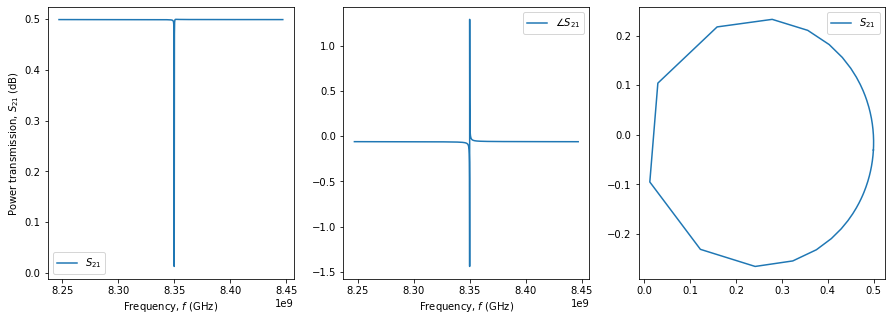

In [40]:
Resonators[0].plot_S21()

In [41]:
fitter=res.fit_S21()

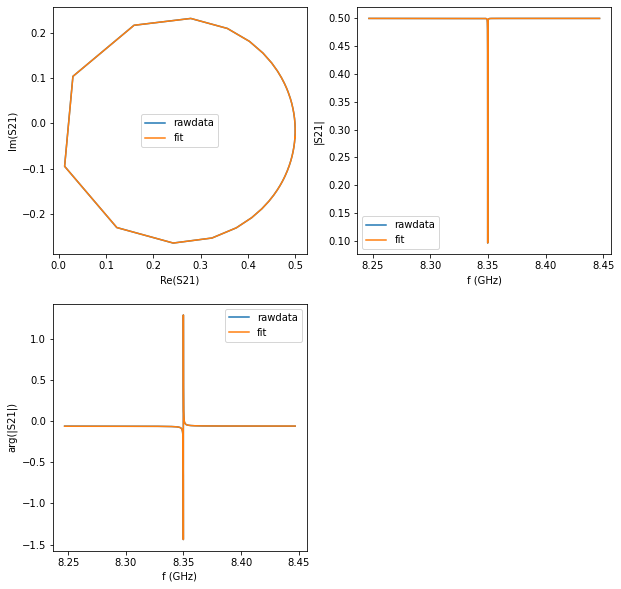

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
fitter.plotall()

In [43]:
fitter.fitresults

{'Qi_dia_corr': 243075205860.25137,
 'Qi_no_corr': 324562852293.27356,
 'absQc': 87345.53104605802,
 'Qc_dia_corr': 87345.53892619415,
 'Ql': 87345.50753985673,
 'fr': 8349874626.6699705,
 'theta0': -3.141167930407307,
 'phi0': 0.0004247774919163716,
 'phi0_err': 0.02642655183422184,
 'Ql_err': 55243.37968913675,
 'absQc_err': 44.90265473554724,
 'fr_err': 1261.3698213852558,
 'chi_square': 6.841299201388535e-07,
 'Qi_no_corr_err': 7.631203033108196e+17,
 'Qi_dia_corr_err': 4.2802809141776154e+17}

In [44]:
(fitter.fitresults['fr']/1e9,fitter.fitresults['fr_err']/1e9)

(8.34987462666997, 1.2613698213852558e-06)

In [45]:
(fitter.fitresults['Ql'],fitter.fitresults['Ql_err'])

(87345.50753985673, 55243.37968913675)